In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

In [2]:
import numpy as np

def angles_between_vectors_batch(vectors1, vectors2):
    # Convert the vectors to numpy arrays
    vectors1 = np.array(vectors1)
    vectors2 = np.array(vectors2)
    
    # Calculate the dot products
    dot_products = np.einsum('ij,ij->i', vectors1, vectors2)
    
    # Calculate the magnitudes (norms) of the vectors
    norms_v1 = np.linalg.norm(vectors1, axis=1)
    norms_v2 = np.linalg.norm(vectors2, axis=1)
    
    # Calculate the cosine of the angles
    cos_angles = dot_products / (norms_v1 * norms_v2)
    
    # Ensure the cosine values are within the valid range
    cos_angles = np.clip(cos_angles, -1.0, 1.0)
    
    # Calculate the angles in radians
    angles_rad = np.arccos(cos_angles)
    
    # Convert the angles to degrees
    angles_deg = np.degrees(angles_rad)
    
    return angles_deg

# Example batches of vectors
vectors1 = [[1, 0], [1, 1], [0, 1]]
vectors2 = [[0, 1], [1, 0], [1, 1]]

# Calculate the angles
angles = angles_between_vectors_batch(vectors1, vectors2)
print(f"The angles between the vector pairs are {angles} degrees")



The angles between the vector pairs are [90. 45. 45.] degrees


In [3]:
def angle_between_vectors(v1, v2):
    # Convert the vectors to numpy arrays
    v1 = np.array(v1)
    v2 = np.array(v2)
    
    # Calculate the dot product
    dot_product = np.dot(v1, v2)
    
    # Calculate the magnitudes (norms) of the vectors
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    # Calculate the cosine of the angle
    cos_angle = dot_product / (norm_v1 * norm_v2)
    
    # Ensure the cosine value is within the valid range
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    
    # Calculate the angle in radians
    angle_rad = np.arccos(cos_angle)
    
    return angle_rad

def get_canonical_3d_same_z_rotate_yaw(world_3d, cam_3d, C):
    num_frames = len(world_3d)
    canonical_3d = world_3d.copy()
    pelvis_z_in_cam_frame = cam_3d[:, 0, 2].copy() # (F,)
    pelvis_in_cam_frame = cam_3d[:, 0].copy() # (F, 3)
    z_axis =np.expand_dims(np.array([0, 0, 1]), 0).repeat(num_frames, axis=0)
    cam_origin = C.copy()
    pelvis = world_3d[:, 0].copy()
    yaw = angle_between_vectors(pelvis_z_in_cam_frame, z_axis)
    mag_cam_origin_to_pelvis = np.expand_dims(pelvis_z_in_cam_frame, axis=1).repeat(3, axis=1) # (F, 3)
    vec_cam_forward = np.multiply(np.expand_dims(R[2], 0).repeat(num_frames, axis=0),  mag_cam_origin_to_pelvis)
    canonical_pelvis = cam_origin + vec_cam_forward
    canonical_3d = canonical_3d - np.expand_dims(pelvis, 1) + np.expand_dims(canonical_pelvis, 1)
    rotate_torso_by_R(canonical_3d, yaw)
    return canonical_3d

In [4]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [5]:
load_folder = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl'
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl_canonical_3d_same_z'
if not os.path.exists(save_folder): os.makedirs(save_folder)

In [6]:
for item in tqdm(glob(load_folder + '/*.pkl')):
    save_path = item.replace('h36m_gt_pkl', 'h36m_gt_pkl_canonical_3d_same_z')
    if os.path.exists(save_path): 
        print('already exists', save_path)
        continue
    data = readpkl(item)
    #print(data.keys())
    new_data = {}
    new_data['joint_2d_from_canonical_3d'] = []
    new_data['joint3d_image_from_canonical_3d'] = []
    
    cam_param = data['cam_param'][0].reshape(1)[0].copy()
    int_mat = cam_param['intrinsic']
    ext_mat = cam_param['extrinsic']
    cam_proj = int_mat @ ext_mat
    R = ext_mat[:3, :3]
    t = ext_mat[:3, 3]
    C = T_to_C(R, t)
    num_frames = len(data['world_3d'])
    world_3d = np.array(data['world_3d']).copy() # (F, J, 3)
    cam_3d = np.array(data['cam_3d']).copy()/1000 # (F, J, 3)
    canonical_3d = get_canonical_3d(world_3d, cam_3d, C, canonical_type='same_z')

    fx, fy, cx, cy = int_mat[0, 0], int_mat[1, 1], int_mat[0, 2], int_mat[1, 2]
    for frame_num in range(num_frames):
        # world to camera
        pos = canonical_3d[frame_num].copy()
        cam_3d = World2CameraCoordinate(pos, cam_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
        cam_3d_hat = get_rootrel_pose(cam_3d)
        
        # camera to image
        box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
        img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
        img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose  
        
        # 2.5d factor
        #pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat) # x,y,z 사용
        
        # joint 2.5d image
        #img_25d = img_3d * pred_lambda
    
        # store
        new_data['joint_2d_from_canonical_3d'].append(np.array(img_2d).copy())
        new_data['joint3d_image_from_canonical_3d'].append(np.array(img_3d).copy())
    
    new_data['joint_2d'] = data['joint_2d'].copy()
    new_data['confidence'] = data['confidence'].copy()
    new_data['camera_name'] = data['camera_name'].copy()
    new_data['action'] = data['action'].copy()
    new_data['source'] = data['source'].copy()
    new_data['frame'] = data['frame'].copy()
    new_data['world_3d'] = data['world_3d'].copy()
    new_data['cam_3d'] = data['cam_3d'].copy()
    new_data['canonical_3d'] = list(canonical_3d)
    new_data['cam_param'] = data['cam_param'].copy()
    savepkl(new_data, save_path)
    #break

100%|██████████| 836/836 [06:25<00:00,  2.17it/s]


In [41]:
data.keys() - new_data.keys()

{'2.5d_factor', 'joint3d_image', 'joints_2.5d_image'}

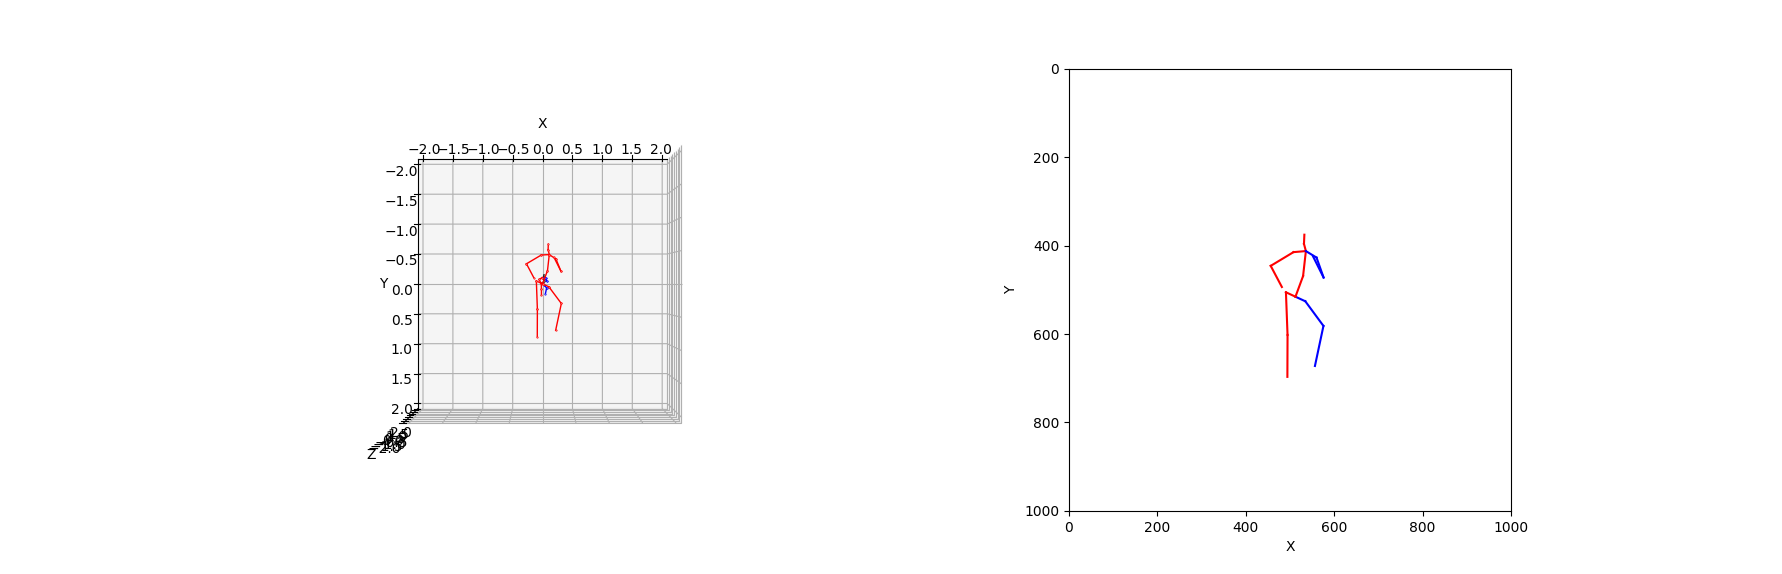

In [60]:
%matplotlib widget
fig = plt.figure(0)
fig.clear()
ax = axes_3d(fig, loc=121, view=(-90,-90))
draw_3d_pose(ax, img_3d_hat/1000)
draw_3d_pose(ax, cam_3d_hat/1000, color='r')
ax2 = axes_2d(fig, loc=122, W=1000, H=1000)
draw_2d_pose(ax2, data['joint_2d_from_canonical_3d'][frame_num])
plt.show()